# Introduction

In this assignment, I fine-tuned pretrained my image classifiers from HW01 using transfer learning techniques and evaluated their performance on a specific task. Through experimentation, I discovered that fine-tuning can significantly enhance the performance of pretrained models, but optimal results depend on careful selection of hyperparameters and model architecture.

## Setup

In [110]:
# Check versions of Keras and Tensorflow
#!pip install -U keras # Don't upgrade Keras for 24SP because hw1 was still Keras 2
!pip list | egrep 'keras|tensorflow\s|jax\s'

jax                                      0.4.23
jupyter-server-mathjax                   0.2.6
keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6
tensorflow                               2.15.0


In [111]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

Keras version: 2.15.0, backend: tensorflow
GPUs: 1


In [112]:
data_dir = Path('/kaggle/input/handwritten-letter-classification-24sp')
!ls {data_dir}

sample_submission.csv  test  test.csv  train  train.csv


In [113]:
train_df = pd.read_csv(data_dir / 'train.csv').sort_values('filename')
train_df['label_as_int'] = ['abc'.index(x) for x in train_df['label']]
test_df = pd.read_csv(data_dir / 'test.csv').sort_values('filename')
train_df.head()

,id,filename,label,label_as_int
0,51,051.png,b,1
1,52,052.png,b,1
2,56,056.png,c,2
3,70,070.jpg,a,0
4,85,085.png,b,1


In [119]:
# REPLACE THIS with the path to your Homework 1 model weights:
# Upload it as either a Dataset or a Model, then find the .weights.h5 file on the right side and click the Copy File Path link.
WEIGHTS_FILENAME = '/kaggle/input/hw0102/hw102.weights.h5'

# Make sure that this config matches the weights you saved (Really only the model_preset should matter.)
class config:
    seed = 155
    learning_rate = 1e-3
    epochs = 4
    batch_size = 10
    image_size = (256, 256)
    model_preset = "efficientnetv2_b2_imagenet"
    use_zero_init = True

In [120]:
# Reproducibility: Set a seed so that the results are the same every time this is run.
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(config.seed)

### Load the competition data

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [121]:
# Define which classes we want to use, in what order.
class_names = ['a', 'b', 'c']

# Create training and validation datasets
def get_dataset(path, labels_as_ints):
    return keras.utils.image_dataset_from_directory(
        path,
        labels=list(labels_as_ints) if labels_as_ints is not None else None,
        label_mode='int' if labels_as_ints is not None else None,
        batch_size=config.batch_size,
        image_size=config.image_size,
        crop_to_aspect_ratio=True,
        shuffle=False
    )

train_dataset = get_dataset(data_dir / 'train', train_df['label_as_int'])
test_dataset = get_dataset(data_dir / 'test', None)

Found 111 files belonging to 3 classes.
Found 2128 files belonging to 1 classes.


Let's show some example images.

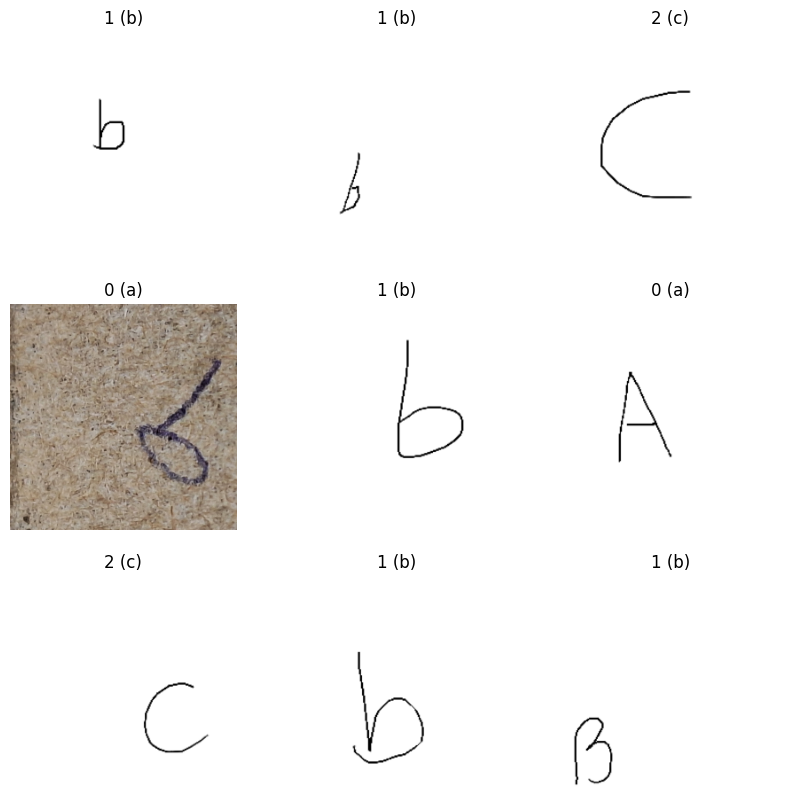

In [122]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')

## Load the model

This code uses the weights file from above.

In [123]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

model.load_weights(WEIGHTS_FILENAME)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier_16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_18 (InputLayer)       [(None, None, None, 3)]   0         Y          
                                                                            
 efficient_net_v2b2_backbon  (None, None, None, 1408   8769374   Y          
 e (EfficientNetV2Backbone)  )                                              
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1408)              0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 3)                 4227      Y          
                                                                            
Total params: 8773601 (33.47 MB)
Trainable para

In [124]:
# This is the code you'd run in the Homework 1 notebook to save the weights file.
# It'll then appear in the "Output" section on the right.
#model.save_weights("hw1.weights.h5")

## Analysis of classifier errors

Use the `train` set as a validation set for diagnosing the classifier's errors.

### Make predictions on test set

This code creates a `submission.csv` file with the labels that `model` gives for the test set.

In [125]:
test_predicted_probs = model.predict(test_dataset)
test_predictions = np.argmax(test_predicted_probs, axis=1)
test_df['label'] = [class_names[x] for x in test_predictions]
test_df[['id', 'label']].to_csv('submission.csv', index=False)

213/213 [==============================] - 9s 26ms/step


# Submission Results & Modifications

- **Baseline**
  - Score: 0.59401(At time of submission, in 9th place)
  - Observations:
     - Noticed my baseline model had a relatively low accuracy socre, showing the model struggled to correctly classify the new dataset images
     - This told me I need to make changes to my model to learn better
- **First Revision**
  - Changes:
    - Changed Model Architecture to Densenet121_imagenet
    - Added Data Augmentation
    - Changed Epochs to 6
    - Kept learning rate at 1e-3
  - Result from these changes:
    - Loss:0.2714 - accuracy: 0.9583 - val_loss:0.1934 - val_accuracy:0.9167
  - Score:
    - 0.74462(Went from 19th place to 13th)
  - Observations:
    - Looking at the baseline model, I wanted to make changes to the model architecture, add data augmentation, and play with the number of epochs. These changes were meant to address the shortcomings observed in the baseline model
    - The changes resulted in a notable improvement in accuracy and validation loss, which showed the model architecture and training parameters were more effective
- **Second Revision**
  - Changes:
    - Changed Model Architecture to efficientnetv2_b2_imagenet
    - Kept same data augmentation from previous revision
    - Changed Epochs to 7
    - Kept Learning Rate at 1e-3
  - Result from these changes:
    - Loss:0.0674 - accuracy:0.9792 - val_loss:0.0307 - val_accuracy:1.0000
  - Score:
    - 0.63517(Score went down)
  - Observations:
    - Even after the last revision, I still wanted to improve my model. So I decided to again change the model architecture and adjust the value of epochs
    - While the result of this revision was good on my data, it did not perform as well on the new dataset. The score slightly decreased, which suggested that additional adjustment would to be made to get better performance

# Analysis

1. **Recall that in Homework 1 you estimated the accuracy that your classifier would obtain on other people’s images. Compare the accuracy you observed from the baseline model to the accuracy that you thought you’d get.**
2. **Read the introduction to Microsoft’s Dataset Documentation (Datasheets for Datasets) template. Then, skim through the questions that follow. Choose two or three questions that are most relevant to how well the model that you trained on that data worked on new data. At the end of your notebook, include both the question texts and your answers. Good answers are those that would most help someone who is training on your dataset predict how it will work on new data.**
3. **Describe what changes you tried in order to improve performance.**


1. The accuracy that I observed from the baseline model was significantly lower than the estimated accuracy in HW01. This demonstrates that the classifier performed worse on unseen data than initially anticipated.

2. 
- How representative is this dataset?
  - Going into HW01, we had a relatively small dataset to work with, which is not widely representative of everyone's handwriting. It's important to understand that the representativeness of a dataset is crucial for assessing its generalization abilities. It also aids in predicting how well the model trained on this dataset will perform on new and unseen data from similar situations.
- How was the data collected? Describe data collection procedures and instruments. Describe who collected the data.
  - For HW01, we used our own letters that we drew ourselves. Therefore, there wasn't much variety in the images, and our model was accustomed to training on our handwriting. When applied to new data, it might be more challenging for the model to predict correctly.
- What demographic groups are identified in the dataset, if any? How were these demographic groups identified?
  - In HW01, the only demographic group represented was my own handwriting. Therefore, the dataset predominantly reflects a 21-year-old male college student in the Midwest. We did not consider other handwriting styles common in different regions, age groups, or genders.

3. Some changes that I tried to improve performance included altering the model architecture. I transitioned from my baseline architecture (EfficientNetV2-B0_imagenet_classifier) to DenseNet121 and also to EfficientNetV2_B2_imagenet_classifier.

# Conclussion

In conclusion, my experiments demonstrate the profound influence of architectural modifications and hyperparameter adjustments on image classifier performance. Transitioning from baseline architectures to more sophisticated models like DenseNet121 and EfficientNetV2_B2, while fine-tuning parameters such as the number of epochs, resulted in significant enhancements in classification accuracy across revisions. These observations underscore the pivotal role of thoughtful model selection and optimization strategies in augmenting the predictive prowess of image classifiers, offering valuable insights for future iterations and real-world application.